# 6-Slot Mini-Nerdle Solver Test
We prove (by brute-force) that you can always solve mini-Nerdle in at most $4$ guesses regardless of the starting expression, provided you use the optimal strategy. The worst start having repeating numbers and thus less information, e.g. `10-5=5`. The best start has all different numbers: `28/7=4`, which needs at most $3$ guesses and $2.65 \pm 0.5$ guesses.

In [1]:
%load_ext autoreload
%autoreload 2

import collections
import ctypes
import itertools
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

import nerdle
import score as s
import generator
sgo = ctypes.CDLL(s.SCORE_GUESS_OPT_SO)
from nerdle import Hint

In [3]:
# Mini-Nerdle.
NUM_SLOTS = 6
SCORE_DB_FILE = "db/nerdle{}.db".format(NUM_SLOTS) 
solver_data = nerdle.create_solver_data(NUM_SLOTS, SCORE_DB_FILE)
d = solver_data.score_db
print(d.shape)

(206, 206)


## Example Usage

In [4]:
score = sgo.score_guess(b"54/9=6", b"4*7=28")
hints = [Hint.ABSENT, Hint.PRESENT, Hint.ABSENT, Hint.ABSENT, Hint.PRESENT, Hint.ABSENT]
print(score, 
      s.score_to_hint_string(score, NUM_SLOTS),
      s.score_to_hints(score, NUM_SLOTS) == hints,
      s.hint_string_to_score(s.score_to_hint_string(score, NUM_SLOTS))
     )

520 -?--?- True 520


In [5]:
# A good initial guess significantly reduces the number of answers. In this case, from
# 206 to 10.
guess_history, hint_history, answer_size_history =  nerdle.NerdleSolver(solver_data).solve("4*3=12", initial_guess="56/7=8", debug=True)

--> guess 56/7=8 guesses_left 5
score ----?- 512
answers 10
--> guess 3+9=12 guesses_left 4
score ?--+++ 1346
answers 1
--> guess 4*3=12 guesses_left 3
score ++++++ 1365


## Initial Guess Optimization

In [6]:
# # For each initial guess, calculate the distribution of #guesses required to get the answer, over all answers.
# # This takes ~1.3s / initial guess = 4.5 min total.
# num_guesses = np.array([
#     [len(nerdle.NerdleSolver(solver_data).solve(answer, initial_guess=start)[1]) for answer in solver_data.answers]
#     for start in solver_data.answers
# ])

In [7]:
# fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# ax = axs[0]
# ax.hist(np.max(num_guesses, axis=1))
# ax.set_title("Max # Guesses")

# ax = axs[1]
# ax.hist(np.mean(num_guesses, axis=1), 30)
# ax.set_title("Mean # Guesses")

# ax = axs[2]
# ax.hist(np.std(num_guesses, axis=1), 30)
# ax.set_title("Stddev of # Guesses");

In [8]:
# # Best starts.
# worst_num_guesses = np.max(num_guesses, axis=1)
# print("Min (max # guesses)", min(worst_num_guesses))
# idx = np.where(worst_num_guesses == min(worst_num_guesses))[0]
# print(idx)
# best_starts = np.array(solver_data.answers)[idx]

# print("Best starts", best_starts)
# mean_best = np.mean(num_guesses[idx], axis=1)
# mean_best_argmin = np.argmin(mean_best)
# print("Best mean # guesses among those {} mean # guesses {:.2f} +- {:.2f} idx {}".format(
#     solver_data.answers[idx[mean_best_argmin]], mean_best[mean_best_argmin], np.std(num_guesses[idx[mean_best_argmin]]),
#     idx[mean_best_argmin]))

# # Worst starts.
# print("Max (max # guesses)", max(worst_num_guesses))
# idx = np.where(worst_num_guesses == max(worst_num_guesses))[0]
# print(idx)
# worst_starts = np.array(solver_data.answers)[idx]

# print("Worst starts", worst_starts)

In [9]:
# # Every initial guess' distribution of #guesses has to have a single "1" value.
# start = best_starts[0]
# solutions = [nerdle.NerdleSolver(solver_data).solve(answer, initial_guess=str(start)) 
#              for answer in solver_data.answers ]               
# n = np.array([len(solution[0]) for solution in solutions])
# num_answers = len(solver_data.answers)
# compression_ratio = num_answers / np.array([solution[2][0] for solution in solutions])
# print(np.mean(compression_ratio), np.std(compression_ratio))

# fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# ax = axs[0]
# ax.hist(n);
# ax.set_title("#Guesses for start {}".format(start));

# ax = axs[1]
# ax.hist(compression_ratio);
# ax.set_title("Compression Ratio Distribution, start {}".format(start));

## #Answers vs. #Slots
As expected, this rises very quickly (expontentially?) with #answers.

In [10]:
slots = np.arange(5, 9)
num_answers = np.array([len(list(generator.all_answers(s))) for s in slots])
print(num_answers)

[  217   206  7561 17723]


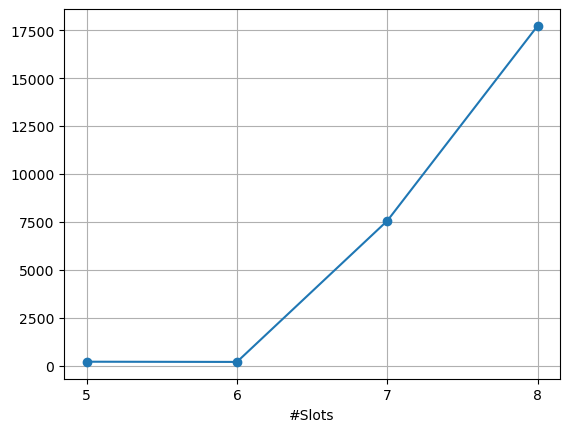

In [11]:
plt.plot(slots, num_answers, 'o-')
plt.xlabel("#Slots");
plt.grid(True);
plt.xticks(slots);

## Benchmarks

In [12]:
%timeit guess_history, hint_history, answer_size_history =  nerdle.NerdleSolver(solver_data).solve("4*3=12", initial_guess="56/7=8")

3.93 ms ± 58.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
for num_slots in range(5, 9):
    print(num_slots)
    %time a = list(generator.all_answers(num_slots));
    print(len(a))

5
CPU times: user 2.28 ms, sys: 6 µs, total: 2.28 ms
Wall time: 2.29 ms
217
6
CPU times: user 45.8 ms, sys: 1.33 ms, total: 47.1 ms
Wall time: 46.4 ms
206
7
CPU times: user 675 ms, sys: 1.84 ms, total: 676 ms
Wall time: 677 ms
7561
8
CPU times: user 10.5 s, sys: 18.7 ms, total: 10.5 s
Wall time: 10.5 s
17723


### Parallel Score Matrix Row Construction

In [8]:
answers = list(generator.all_answers(8))

In [57]:
n = 2000
a = answers[:n]
%time result = [nerdle._score_guess(guess, answer) for guess in a for answer in a]

CPU times: user 2.54 s, sys: 40.2 ms, total: 2.58 s
Wall time: 2.59 s


In [58]:
with multiprocessing.Pool(8) as pool:
    %time result1 = pool.starmap(nerdle._score_guess, itertools.product(a, repeat=2))

CPU times: user 1.35 s, sys: 234 ms, total: 1.58 s
Wall time: 1.76 s


In [59]:
# with multiprocessing.Pool(multiprocessing.cpu_count() // 2) as pool:
#     %time result2 = [pool.apply_async(nerdle._score_guess, t).get() for t in itertools.product(a, repeat=2)]

In [60]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [ ]:
# with ProcessPoolExecutor(max_workers=4) as pool:
#     %time result1 = pool.map(nerdle._score_guess, itertools.product(a, repeat=2))

In [74]:
from test_parallel import square

n = 10000000
with multiprocessing.Pool(processes=4) as pool:
    %time results = pool.map(square, itertools.repeat(3, n))

CPU times: user 589 ms, sys: 227 ms, total: 816 ms
Wall time: 1.1 s


In [94]:
from test_parallel import process_one_arg

n = 30000000
print(n, n ** 0.5)
%time results = [process_one_arg("54/9=6") for _ in range(n)]
with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
    %time results = pool.map(process_one_arg, itertools.repeat("54/9=6", n))

30000000 5477.2255750516615
CPU times: user 15.5 s, sys: 411 ms, total: 15.9 s
Wall time: 15.9 s
CPU times: user 3.46 s, sys: 1.25 s, total: 4.71 s
Wall time: 5.62 s


In [130]:
from test_parallel import process_args

n = 2000
a = answers[:n]
%time result = [[nerdle._score_guess(guess, answer) for answer in a] for guess in a]

with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
    %time result2 = pool.map(process_args, itertools.product(a, repeat=2))
result == result2

CPU times: user 2.74 s, sys: 112 ms, total: 2.85 s
Wall time: 2.86 s
CPU times: user 1.53 s, sys: 271 ms, total: 1.8 s
Wall time: 2.3 s


False

In [129]:
np.array_equal(np.array(result2).reshape(n, n), np.array(result))

True